# Trading Strategies powered by Machine Learning - Regression

## Linear Regression with scikit-learn - a Simple Introduction

In [32]:
import sys
sys.path.append('../../')

In [33]:
from util.load_data import *
from config.constants import *
from util.plot_equity import plot_equity_trades
from util.Save_result_return import save_to_csv

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.style.use("seaborn-v0_8")

In [35]:
import warnings
warnings.simplefilter("ignore")

In [36]:
from backtesting import Strategy

## Getting the Data

In [37]:
XAUUSD = load_data()

In [38]:
XAUUSD['H4'].Close

Time
2007-01-01 00:00:00     635.497
2007-01-01 04:00:00     635.699
2007-01-01 08:00:00     635.993
2007-01-01 12:00:00     636.006
2007-01-01 16:00:00     635.989
                         ...   
2023-03-10 00:00:00    1829.085
2023-03-10 04:00:00    1833.405
2023-03-10 08:00:00    1834.865
2023-03-10 12:00:00    1862.975
2023-03-10 16:00:00    1864.098
Name: Close, Length: 25976, dtype: float64

In [39]:
XAUUSD['H4'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25976 entries, 2007-01-01 00:00:00 to 2023-03-10 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    25976 non-null  float64
 1   High    25976 non-null  float64
 2   Low     25976 non-null  float64
 3   Close   25976 non-null  float64
 4   Volume  25976 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


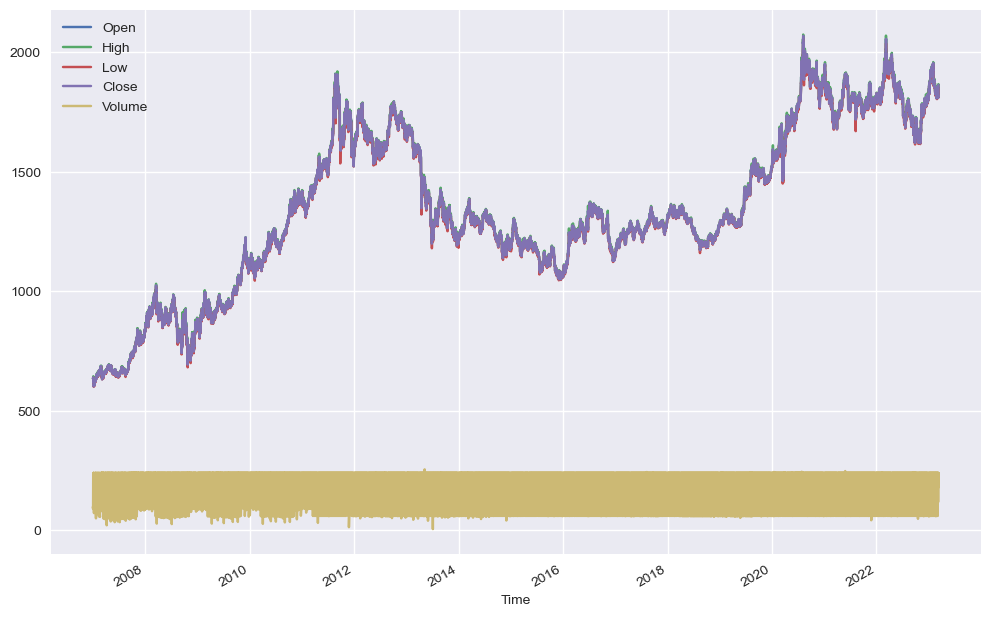

In [40]:
XAUUSD['H4'].plot(figsize = (12, 8))
plt.show()

## ML

### Class and Strategy ML

In [41]:
class Linear_Regression(Strategy):

    def init(self):
        pass

    def next(self):

        if self.data.pred[-1] == 1:
            if not self.position :
                self.buy(size=1)
            elif self.position.is_short:
                self.position.close()
                self.buy(size=1)
            
        elif self.data.pred[-1] == -1:
            if not self.position:
                self.sell(size=1)
            elif self.position.is_long:
                self.position.close()
                self.sell(size=1)

        

In [42]:
strategy = Linear_Regression
account_size = 10000
folder_ML_Strategy = 'Linear Regression'

In [43]:
from backtesting import Backtest
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from util.Save_result_return import save_to_csv
import sys
sys.path.append('../../')


plt.style.use("seaborn-v0_8")


class ML_Regression():

    def __init__(self, data, strategy, start_train, start_test, end_train, end_test, TF, account_size):
        self.data = data
        self.strategy = strategy
        self.start_train = start_train
        self.start_test = start_test
        self.end_train = end_train
        self.end_test = end_test
        self.TF = TF
        self.data_train = None
        self.data_test = None
        self.results = None
        self.model = None
        self.account_size = account_size

    def Prepare(self, lags=0):
        data = self.data.loc[self.start_train:self.end_train].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        data["returns_signal"] = data["returns"].shift(-1)
        # data.dropna(inplace=True)
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)

        lm = LinearRegression(fit_intercept=True)
        lm.fit(data[cols], data['returns_signal'])
        data["pred"] = lm.predict(data[cols])
        data['pred'] = np.sign(data['pred'])


        self.model = lm
        self.data_train = data.copy()

    def Predict(self, lags=0):
        data = self.data.loc[self.start_test:self.end_test].copy()
        data["returns"] = np.log(data['Close'].div(data['Close'].shift(1)))
        
        cols = []

        for lag in range(lags + 1):
            col = "lag{}".format(lag)
            data[col] = data['returns'].shift(lag)
            cols.append(col)
        # data.dropna(inplace=True)
        data.fillna(0, inplace=True)

        data["pred"] = self.model.predict(data[cols])
        data['pred'] = np.sign(data['pred'])

        self.data_test = data.copy()

    def Backtest(self, data):
        # Assuming you have a Backtest class that performs backtesting
        backtest = Backtest(data, self.strategy,
                            cash=self.account_size, margin=1/100, commission=0.0002)
        result = backtest.run()
        return result

    def Save_Result(self, df, file_path):

        equity_curve = df['_equity_curve'].copy()
        equity_df = pd.DataFrame(equity_curve, columns=['Equity'])
        equity_df['returns'] = equity_df['Equity'].pct_change().fillna(0)
        equity_df = equity_df.drop('Equity', axis=1)
        equity_df.to_csv(file_path, index=True)

    def Run(self):
        self.Prepare()
        result_train = self.Backtest(self.data_train)
        self.Predict()
        result_test = self.Backtest(self.data_test)
       

        return result_train, result_test

## TF D1

In [44]:
data = XAUUSD['D1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'D1'


In [45]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [46]:
train , test = ml.Run()

### In-Sample Backtesting

In [47]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 00:00:00
Duration                   4747 days 00:00:00
Exposure Time [%]                   99.950642
Equity Final [$]                 10875.661194
Equity Peak [$]                  11269.921194
Return [%]                           8.756612
Buy & Hold Return [%]              138.530025
Return (Ann.) [%]                    0.523415
Volatility (Ann.) [%]                1.804103
Sharpe Ratio                         0.290125
Sortino Ratio                        0.399885
Calmar Ratio                         0.068889
Max. Drawdown [%]                   -7.597915
Avg. Drawdown [%]                   -0.353007
Max. Drawdown Duration     3053 days 00:00:00
Avg. Drawdown Duration       67 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     137.002561
Worst Trade [%]                    137.002561
Avg. Trade [%]                    

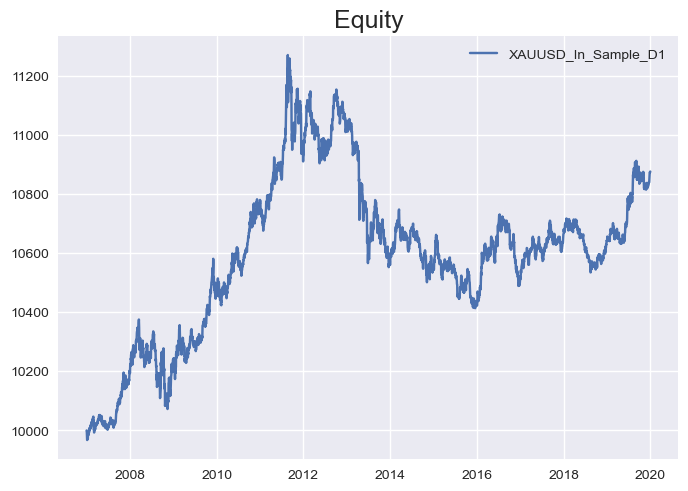

In [48]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [49]:
test

Start                     2020-01-01 00:00:00
End                       2023-03-10 00:00:00
Duration                   1164 days 00:00:00
Exposure Time [%]                   99.798184
Equity Final [$]                 10302.394254
Equity Peak [$]                  10540.144254
Return [%]                           3.023943
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    0.760434
Volatility (Ann.) [%]                2.594973
Sharpe Ratio                         0.293041
Sortino Ratio                         0.39972
Calmar Ratio                         0.181193
Max. Drawdown [%]                   -4.196812
Avg. Drawdown [%]                   -0.633509
Max. Drawdown Duration      946 days 00:00:00
Avg. Drawdown Duration       71 days 00:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                       19.77682
Worst Trade [%]                      19.77682
Avg. Trade [%]                    

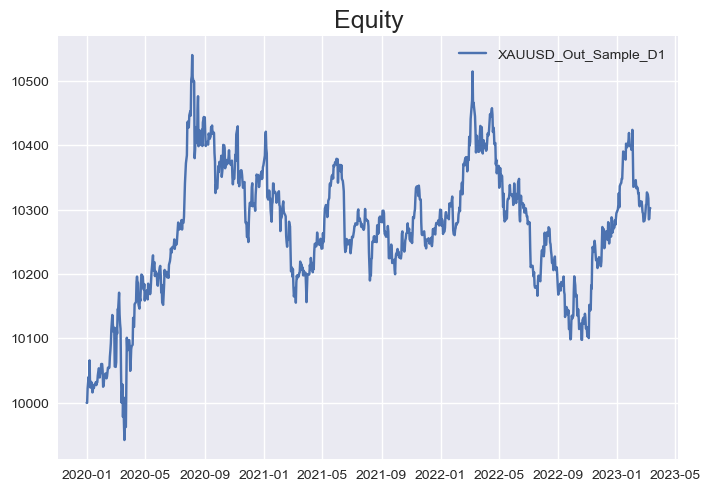

In [50]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [51]:
filename_train = f'result_{TF}_In_Sample.csv'

In [52]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [53]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [54]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H4

In [55]:
data = XAUUSD['H4']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H4'


In [56]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [57]:
train , test = ml.Run()

### In-Sample Backtesting

In [58]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 20:00:00
Duration                   4747 days 20:00:00
Exposure Time [%]                   99.990417
Equity Final [$]                 10883.780844
Equity Peak [$]                  11273.170844
Return [%]                           8.837808
Buy & Hold Return [%]              138.697429
Return (Ann.) [%]                    0.528058
Volatility (Ann.) [%]                1.803683
Sharpe Ratio                         0.292767
Sortino Ratio                        0.403555
Calmar Ratio                         0.069332
Max. Drawdown [%]                   -7.616366
Avg. Drawdown [%]                   -0.185931
Max. Drawdown Duration     3053 days 00:00:00
Avg. Drawdown Duration       26 days 19:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                     138.979541
Worst Trade [%]                    138.979541
Avg. Trade [%]                    

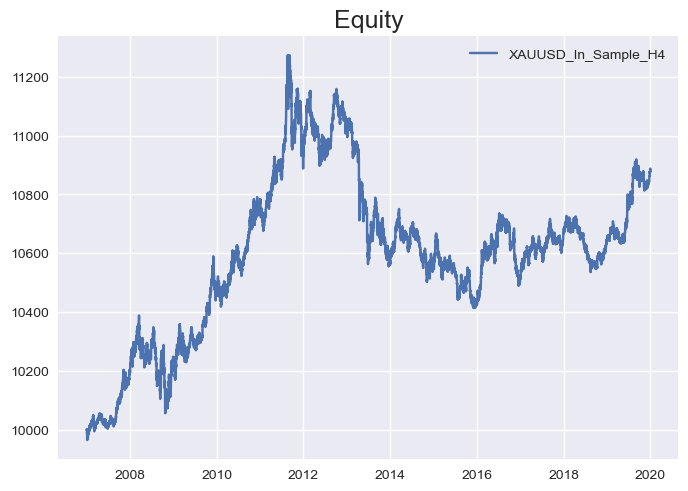

In [59]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [60]:
test

Start                     2020-01-01 20:00:00
End                       2023-03-10 16:00:00
Duration                   1163 days 20:00:00
Exposure Time [%]                   99.960823
Equity Final [$]                 10342.405945
Equity Peak [$]                  10548.598945
Return [%]                           3.424059
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                      0.8598
Volatility (Ann.) [%]                2.600336
Sharpe Ratio                         0.330649
Sortino Ratio                        0.452323
Calmar Ratio                         0.201768
Max. Drawdown [%]                   -4.261334
Avg. Drawdown [%]                   -0.299031
Max. Drawdown Duration      945 days 20:00:00
Avg. Drawdown Duration       26 days 20:00:00
# Trades                                    1
Win Rate [%]                            100.0
Best Trade [%]                      22.518128
Worst Trade [%]                     22.518128
Avg. Trade [%]                    

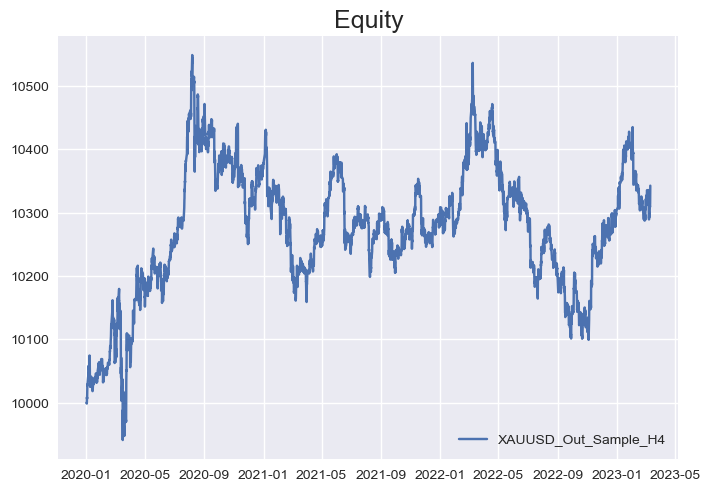

In [61]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [62]:
filename_train = f'result_{TF}_In_Sample.csv'

In [63]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [64]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [65]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF H1

In [66]:
data = XAUUSD['H1']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'H1'


In [67]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [68]:
train , test = ml.Run()

### In-Sample Backtesting

In [69]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:00:00
Duration                   4747 days 21:00:00
Exposure Time [%]                   99.997471
Equity Final [$]                  9712.414624
Equity Peak [$]                   11077.93356
Return [%]                          -2.875854
Buy & Hold Return [%]              138.649736
Return (Ann.) [%]                   -0.181585
Volatility (Ann.) [%]                1.854643
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.029781
Avg. Drawdown [%]                   -0.158801
Max. Drawdown Duration     3038 days 16:00:00
Avg. Drawdown Duration       17 days 06:00:00
# Trades                                 3305
Win Rate [%]                        55.763994
Best Trade [%]                       5.240521
Worst Trade [%]                    -11.391378
Avg. Trade [%]                    

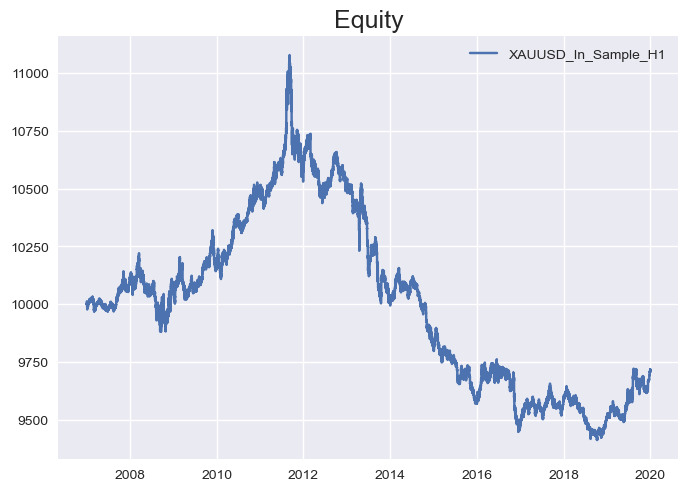

In [70]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [71]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:00:00
Duration                   1163 days 18:00:00
Exposure Time [%]                   99.989397
Equity Final [$]                 10395.203821
Equity Peak [$]                  10624.958231
Return [%]                           3.952038
Buy & Hold Return [%]               22.776554
Return (Ann.) [%]                    0.990481
Volatility (Ann.) [%]                2.605527
Sharpe Ratio                         0.380146
Sortino Ratio                        0.530732
Calmar Ratio                         0.247325
Max. Drawdown [%]                   -4.004779
Avg. Drawdown [%]                   -0.226014
Max. Drawdown Duration      553 days 11:00:00
Avg. Drawdown Duration       12 days 21:00:00
# Trades                                  655
Win Rate [%]                        55.572519
Best Trade [%]                       4.230027
Worst Trade [%]                     -5.988012
Avg. Trade [%]                    

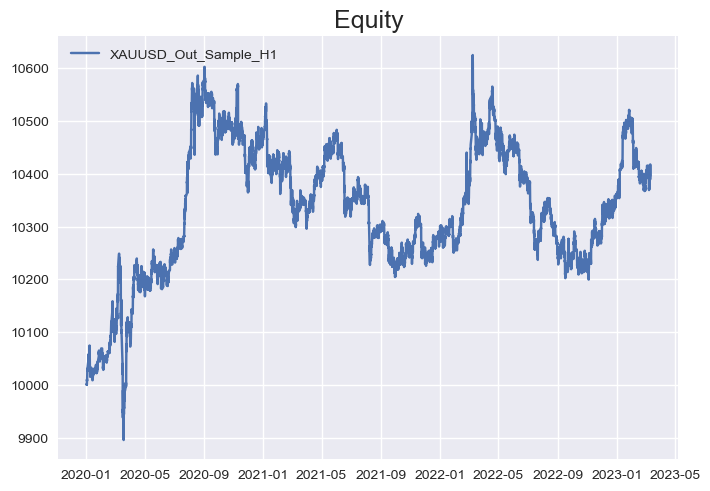

In [72]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [73]:
filename_train = f'result_{TF}_In_Sample.csv'

In [74]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [75]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [76]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M30

In [77]:
data = XAUUSD['M30']
start_train = '2007'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M30'


In [78]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [79]:
train , test = ml.Run()

### In-Sample Backtesting

In [80]:
train

Start                     2007-01-01 00:00:00
End                       2019-12-31 21:30:00
Duration                   4747 days 21:30:00
Exposure Time [%]                    99.99873
Equity Final [$]                  2953.342617
Equity Peak [$]                  10049.011975
Return [%]                         -70.466574
Buy & Hold Return [%]              138.705317
Return (Ann.) [%]                   -7.304944
Volatility (Ann.) [%]                2.706928
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -70.876203
Avg. Drawdown [%]                   -1.535887
Max. Drawdown Duration     4701 days 02:00:00
Avg. Drawdown Duration      101 days 00:05:00
# Trades                                41439
Win Rate [%]                        54.878255
Best Trade [%]                       3.207378
Worst Trade [%]                     -6.187999
Avg. Trade [%]                    

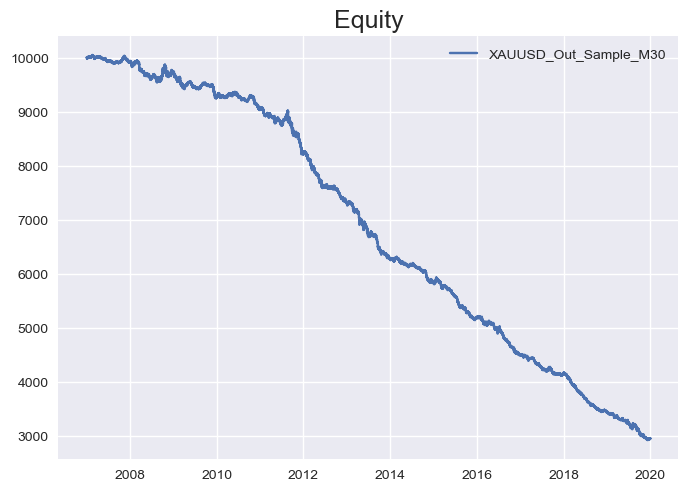

In [81]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [82]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:30:00
Duration                   1163 days 18:30:00
Exposure Time [%]                   99.994697
Equity Final [$]                  7787.445444
Equity Peak [$]                  10071.310893
Return [%]                         -22.125546
Buy & Hold Return [%]               22.670469
Return (Ann.) [%]                   -6.161082
Volatility (Ann.) [%]                2.624543
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -23.304907
Avg. Drawdown [%]                   -1.324281
Max. Drawdown Duration     1157 days 18:30:00
Avg. Drawdown Duration       64 days 12:17:00
# Trades                                10524
Win Rate [%]                        54.285443
Best Trade [%]                       2.847547
Worst Trade [%]                     -5.182778
Avg. Trade [%]                    

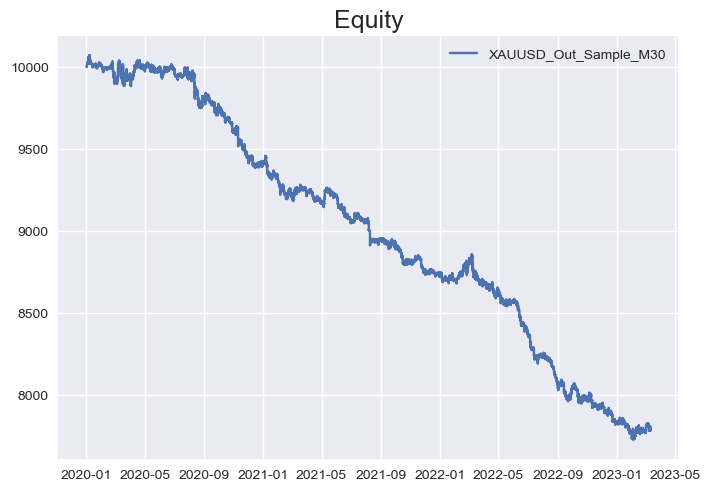

In [83]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [84]:
filename_train = f'result_{TF}_In_Sample.csv'

In [85]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [86]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [87]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M15

In [88]:
data = XAUUSD['M15']
start_train = '2014'
start_test = '2020'
end_train = '2019'
end_test = '2023'
TF = 'M15'


In [89]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [90]:
train , test = ml.Run()

### In-Sample Backtesting

In [91]:
train

Start                     2014-09-23 13:00:00
End                       2019-12-31 21:45:00
Duration                   1925 days 08:45:00
Exposure Time [%]                   70.738775
Equity Final [$]                    10.923971
Equity Peak [$]                  10001.052645
Return [%]                          -99.89076
Buy & Hold Return [%]                23.74151
Return (Ann.) [%]                   -64.92849
Volatility (Ann.) [%]               11.814336
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.913169
Avg. Drawdown [%]                  -99.913169
Max. Drawdown Duration     1925 days 08:15:00
Avg. Drawdown Duration     1925 days 08:15:00
# Trades                                42052
Win Rate [%]                        47.797964
Best Trade [%]                       1.562534
Worst Trade [%]                     -2.609014
Avg. Trade [%]                    

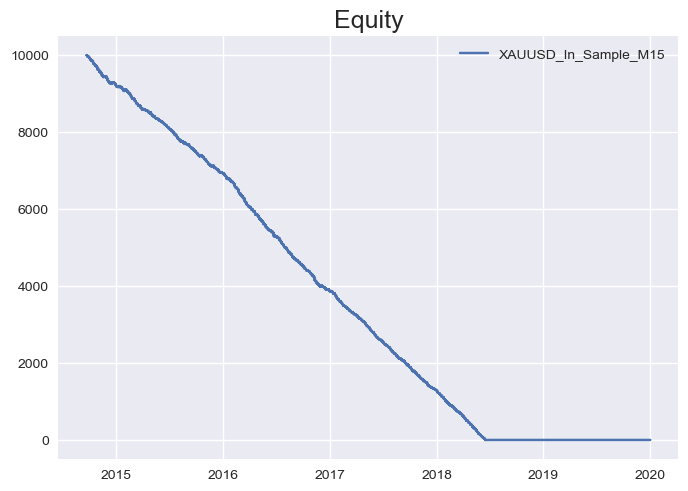

In [92]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [93]:
test

Start                     2020-01-01 23:00:00
End                       2023-03-10 17:45:00
Duration                   1163 days 18:45:00
Exposure Time [%]                    91.69285
Equity Final [$]                    17.096743
Equity Peak [$]                       10000.0
Return [%]                         -99.829033
Buy & Hold Return [%]               22.657555
Return (Ann.) [%]                  -80.213036
Volatility (Ann.) [%]                8.717754
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.835043
Avg. Drawdown [%]                  -99.835043
Max. Drawdown Duration     1163 days 18:30:00
Avg. Drawdown Duration     1163 days 18:30:00
# Trades                                33728
Win Rate [%]                        51.630693
Best Trade [%]                       1.642139
Worst Trade [%]                     -3.492069
Avg. Trade [%]                    

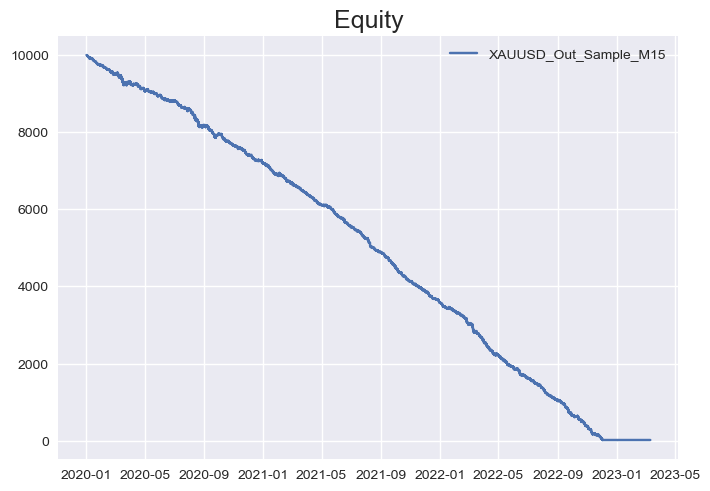

In [94]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [95]:
filename_train = f'result_{TF}_In_Sample.csv'

In [96]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [97]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [98]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M5

In [99]:
data = XAUUSD['M5']
start_train = '2020'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M5'


In [100]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [101]:
train , test = ml.Run()

### In-Sample Backtesting

In [102]:
train

Start                     2020-05-15 11:10:00
End                       2022-12-30 21:55:00
Duration                    959 days 10:45:00
Exposure Time [%]                   33.568948
Equity Final [$]                          0.0
Equity Peak [$]                  10001.586375
Return [%]                             -100.0
Buy & Hold Return [%]                5.144305
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]              154.419805
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                      -100.0
Avg. Drawdown [%]                      -100.0
Max. Drawdown Duration      959 days 10:30:00
Avg. Drawdown Duration      959 days 10:30:00
# Trades                                32654
Win Rate [%]                        41.771299
Best Trade [%]                       0.849974
Worst Trade [%]                     -2.155279
Avg. Trade [%]                    

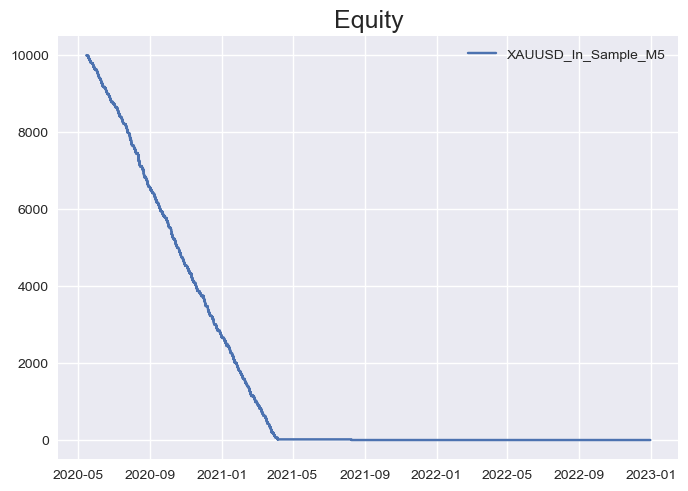

In [103]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [104]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:55:00
Duration                     66 days 18:55:00
Exposure Time [%]                    99.98507
Equity Final [$]                  7579.615555
Equity Peak [$]                  10002.854113
Return [%]                         -24.203844
Buy & Hold Return [%]                2.045231
Return (Ann.) [%]                  -69.359989
Volatility (Ann.) [%]                1.124241
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -24.225471
Avg. Drawdown [%]                  -24.225471
Max. Drawdown Duration       66 days 18:45:00
Avg. Drawdown Duration       66 days 18:45:00
# Trades                                 6921
Win Rate [%]                        37.220055
Best Trade [%]                       0.453433
Worst Trade [%]                     -1.401702
Avg. Trade [%]                    

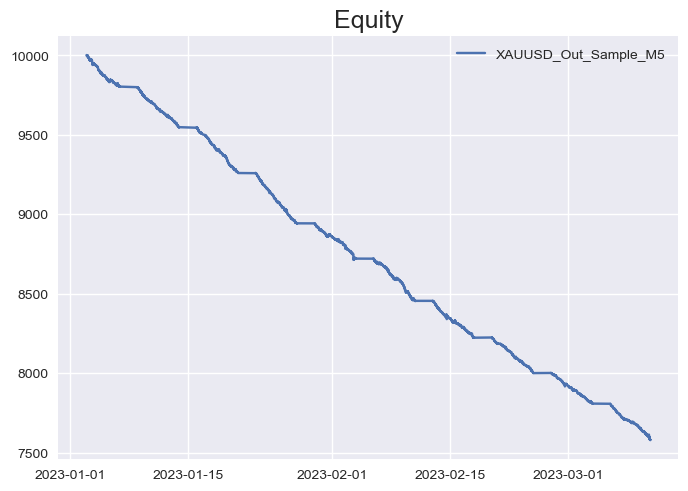

In [105]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [106]:
filename_train = f'result_{TF}_In_Sample.csv'

In [107]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [108]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [109]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')

## TF M1

In [110]:
data = XAUUSD['M1']
start_train = '2022'
start_test = '2023'
end_train = '2022'
end_test = '2023'
TF = 'M1'


In [111]:
ml = ML_Regression(data,strategy,start_train,start_test,end_train,end_test,TF,account_size)

In [112]:
train , test = ml.Run()

### In-Sample Backtesting

In [113]:
train

Start                     2022-08-16 23:13:00
End                       2022-12-30 21:58:00
Duration                    135 days 22:45:00
Exposure Time [%]                   43.982682
Equity Final [$]                    15.247757
Equity Peak [$]                       10000.0
Return [%]                         -99.847522
Buy & Hold Return [%]                2.688945
Return (Ann.) [%]                  -99.999914
Volatility (Ann.) [%]                0.000506
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.850242
Avg. Drawdown [%]                  -99.850242
Max. Drawdown Duration      135 days 22:44:00
Avg. Drawdown Duration      135 days 22:44:00
# Trades                                28962
Win Rate [%]                        17.837166
Best Trade [%]                       0.730694
Worst Trade [%]                     -0.794801
Avg. Trade [%]                    

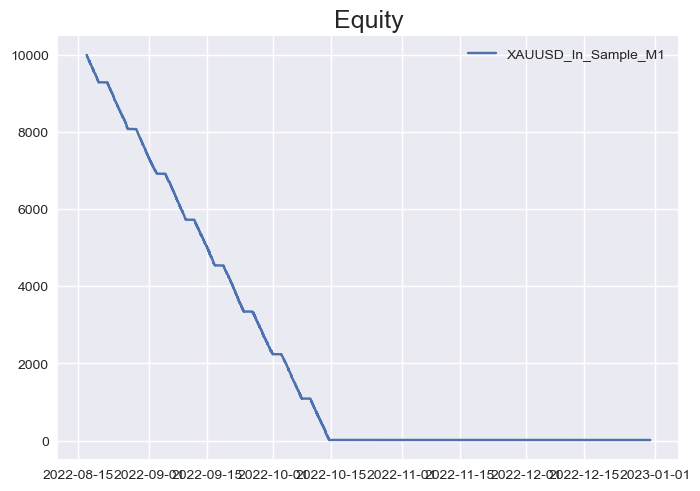

In [114]:
plot_equity_trades(train['_equity_curve'],
                   f'XAUUSD_In_Sample_{TF}', account_size)

### Out-Sample Backtesting

In [115]:
test

Start                     2023-01-02 23:00:00
End                       2023-03-10 17:59:00
Duration                     66 days 18:59:00
Exposure Time [%]                   78.008931
Equity Final [$]                    17.636596
Equity Peak [$]                  10000.234773
Return [%]                         -99.823634
Buy & Hold Return [%]                2.050818
Return (Ann.) [%]                      -100.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -99.839538
Avg. Drawdown [%]                  -99.839538
Max. Drawdown Duration       66 days 18:57:00
Avg. Drawdown Duration       66 days 18:57:00
# Trades                                26163
Win Rate [%]                         16.48129
Best Trade [%]                       0.486551
Worst Trade [%]                     -0.547082
Avg. Trade [%]                    

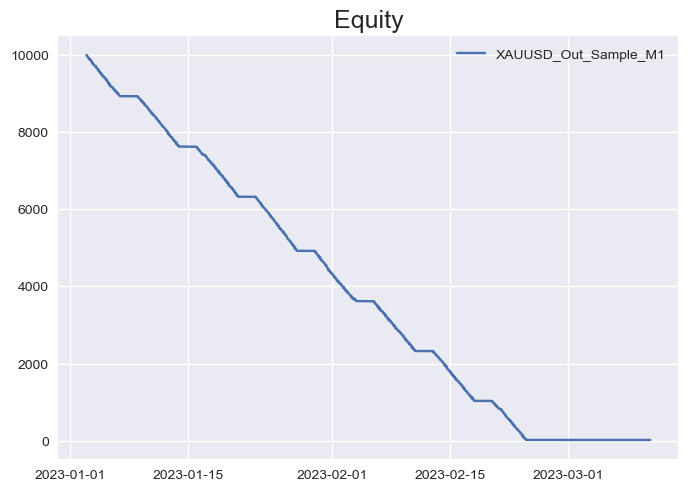

In [116]:
plot_equity_trades(test['_equity_curve'],
                   f'XAUUSD_Out_Sample_{TF}', account_size)

### Save result 

In [117]:
filename_train = f'result_{TF}_In_Sample.csv'

In [118]:
save_to_csv(
    train, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_train}')

In [ ]:
filename_test = f'result_{TF}_Out_Sample.csv'

In [ ]:
save_to_csv(
    test, f'../../out/Machine_Learning/{folder_ML_Strategy}/Backtest/{filename_test}')